In [1]:
%load_ext autoreload
%autoreload 2
import gym
import time
import threading
import numpy as np
import ipywidgets as widgets
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.enable_eager_execution(config=config)

# Advantage Actor-Critic

In [19]:
class CriticModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(CriticModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        
        self.value_dense_1 = layers.Dense(128, activation='relu')
        self.value_dense_2 = layers.Dense(128, activation='relu')
        self.values = layers.Dense(1)

    def call(self, inputs):
        input_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
        y = self.value_dense_1(input_tensor)
        y = self.value_dense_2(y)
        values = self.values(y)
        return values
    
class ActorModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(ActorModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        
        self.policy_dense_1 = layers.Dense(128, activation='relu')
        self.policy_dense_2 = layers.Dense(128, activation='relu')
        self.policy_logits = layers.Dense(action_size)

    def call(self, inputs):
        input_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
        x = self.policy_dense_1(input_tensor)
        x = self.policy_dense_2(x)
        logits = self.policy_logits(x)
        return logits
    
class ActorCriticModel(keras.Model):
    def __init__(self, observation_size, action_size):
        super(ActorCriticModel, self).__init__()
        self.observation_size = observation_size
        self.action_size = action_size
        self.actor = ActorModel(observation_size, action_size)
        self.critic = CriticModel(observation_size, action_size)
        
    def call(self, inputs):
        return self.actor(inputs), self.critic(inputs)

class HyperParameters:
    def __init__(self, **kw):
        self.gamma = 0.99
        self.vf_coef = 0.5
        self.ent_coef = 0.01
        self.lr = 0.001
        self.__dict__.update(kw)
        
def vanilla_loss(a2c, observations, actions, probabilities, discounted_rewards, hyperparameters, verbose=False, normalize_discounted_rewards=True, *args, **kargs):
    hp = hyperparameters
    
    logits, values = a2c(tf.convert_to_tensor(observations, dtype=tf.float32))
    values = tf.squeeze(values)

    if normalize_discounted_rewards:
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)

    discounted_rewards = tf.convert_to_tensor(np.array(discounted_rewards), dtype=tf.float32)
    advantages =  tf.stop_gradient(discounted_rewards) - values

    critic_loss = advantages ** 2

    policy = tf.nn.softmax(logits)
    entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=policy, logits=logits)

    actor_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=actions, logits=logits)
    actor_loss *= tf.stop_gradient(advantages)
    actor_loss -= hp.ent_coef * entropy

    total_loss = tf.reduce_mean(hp.vf_coef * critic_loss + actor_loss)

    if verbose:
        variables = dir()[:]
        for key in variables:
            print(key)
            print(locals()[key])
    
    return total_loss

def run(env, a2c, verbose=False, *args, **kargs):
    obs = env.reset()
    done = False
    rewards = []
    actions = []
    probabilities = []
    observations = []
        
    while not done:
        logits, _ = a2c(tf.convert_to_tensor(obs[None, :], dtype=tf.float32))
        probs = tf.nn.softmax(logits)
        action = np.random.choice(env.action_space.n, p=probs.numpy()[0])

        next_obs, reward, done, info = env.step(action)
        
        if done:
            reward = -1
        
        observations.append(obs)
        actions.append(action)
        probabilities.append(probs)
        rewards.append(reward)
        
        obs = next_obs
        total_reward = np.sum(rewards)
        
        if verbose:
            variables = dir()[:]
            for key in variables:
                print(key)
                print(locals()[key])
            
        if done:
            return observations, actions, probabilities, rewards
        
def learn(a2c, loss, observations, actions, probabilities, discounted_rewards, hyperparameters, *args, **kargs):
    opt = tf.train.AdamOptimizer(hp.lr, use_locking=True)
    with tf.GradientTape() as tape:
        total_loss = loss(a2c, observations, actions, probabilities, discounted_rewards, hyperparameters=hp, **kargs)

    grads = tape.gradient(total_loss, a2c.trainable_weights)
    opt.apply_gradients(zip(grads, a2c.trainable_weights))
    
def get_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    reward_sum = 0
    for reward in rewards[::-1]:
        reward_sum = reward + gamma * reward_sum
        discounted_rewards.append(reward_sum)
    discounted_rewards.reverse()
    return discounted_rewards

In [98]:
env = gym.make('CartPole-v1')
#env = gym.make('LunarLander-v2')
a2c = ActorCriticModel(env.observation_space.shape[0], env.action_space.n)
a2c(tf.convert_to_tensor(np.random.random((1, a2c.observation_size)), dtype=tf.float32))

hp = HyperParameters(gamma = 0.99, vf_coef = 0.5, ent_coef = 0.001, lr = 0.001)

start_time = time.time()
batch = {
    "observations": [],
    "actions": [],
    "probabilities": [],
    "discounted_rewards": []
}

ep_rewards = []
episodes = 100
episode = 0
epochs = 64
batch_size = 512
while episode < episodes:
    observations, actions, probs, rewards = run(env, a2c, verbose=0)
    ep_rewards.append(np.sum(rewards))
    
    # Calculate True Discounted Rewards
    discounted_rewards = get_discounted_rewards(rewards, hp.gamma)
    
    batch['observations'] += observations
    batch['actions'] += actions
    batch['probabilities'] += probs
    batch['discounted_rewards'] += discounted_rewards

    if len(batch['observations']) >= batch_size:
        print(f"Ep {episode} ({time.time() - start_time:.3f}s): {np.mean(ep_rewards[-10:])}")
        for epoch in range(epochs):
            learn(a2c, vanilla_loss, hyperparameters=hp, lock_actor=True, **batch)
        batch = {
            "observations": [],
            "actions": [],
            "probabilities": [],
            "discounted_rewards": []
        }
    episode += 1
    
end_time = time.time()
print(end_time - start_time)

Ep 21 (0.419s): 23.3
Ep 25 (22.953s): 84.4
Ep 32 (46.638s): 111.8
Ep 36 (70.235s): 100.4
Ep 43 (94.370s): 94.3
Ep 47 (119.162s): 105.0
Ep 49 (144.318s): 142.9
Ep 52 (170.448s): 186.4
Ep 55 (197.161s): 210.1
Ep 58 (224.524s): 216.9
Ep 61 (252.565s): 208.5
Ep 64 (281.150s): 205.0
Ep 67 (310.305s): 196.4
Ep 70 (340.188s): 192.0
Ep 74 (370.561s): 171.2
Ep 76 (401.809s): 193.0
Ep 79 (433.577s): 198.2
Ep 83 (465.890s): 192.2
Ep 87 (498.924s): 168.5
Ep 90 (532.316s): 172.8
Ep 92 (566.457s): 195.2
Ep 99 (601.339s): 160.3
636.3940904140472


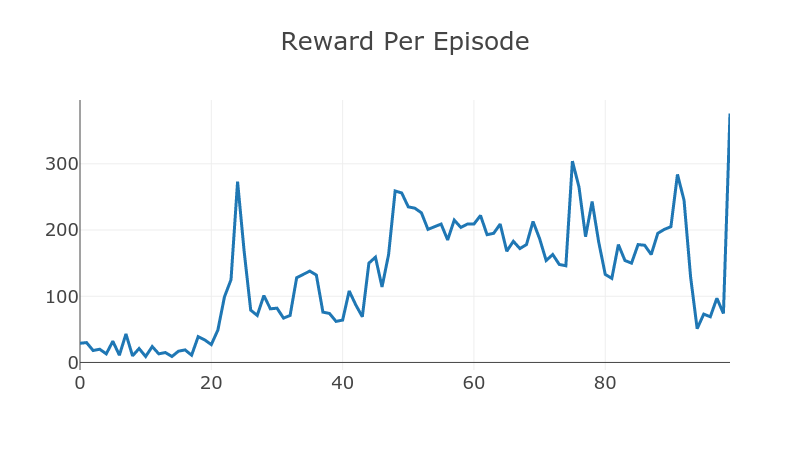

In [99]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(ep_rewards)), y=moving_average(ep_rewards, 1))],
    "layout": go.Layout(title="Reward Per Episode", template="presentation")
})

# Proximal Policy Optimization

In [93]:
def ppo_loss(a2c, observations, actions, probs, discounted_rewards, hyperparameters, verbose=False, normalize_discounted_rewards=True, *args, **kargs):
    hp = hyperparameters
    
    logits, values = a2c(tf.convert_to_tensor(observations, dtype=tf.float32))
    values = tf.squeeze(values)
    probs = tf.squeeze(probs)

    if normalize_discounted_rewards:
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)

    discounted_rewards = tf.convert_to_tensor(np.array(discounted_rewards), dtype=tf.float32)
    advantages =  tf.stop_gradient(discounted_rewards) - values

    critic_loss = advantages ** 2

    policy = tf.nn.softmax(logits)
    entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=policy, logits=logits)
    
    r = policy/probs
    one_hot_actions = tf.one_hot(actions, policy.shape[1])
    adv = tf.multiply(tf.expand_dims(tf.stop_gradient(advantages), axis=1), one_hot_actions)
    actor_loss = tf.minimum(
        r*adv,
        tf.clip_by_value(r, 1-hp.eps, 1+hp.eps)*adv
    )
    actor_loss = -tf.reduce_sum(actor_loss, axis=1)
    actor_loss += hp.ent_coef * entropy

    total_loss = tf.reduce_mean(hp.vf_coef * critic_loss + actor_loss)

    if verbose:
        variables = dir()[:]
        for key in variables:
            print(key)
            print(locals()[key])
    
    return total_loss

In [96]:
env = gym.make('CartPole-v1')
#env = gym.make('LunarLander-v2')
a2c = ActorCriticModel(env.observation_space.shape[0], env.action_space.n)
a2c(tf.convert_to_tensor(np.random.random((1, a2c.observation_size)), dtype=tf.float32))

hp = HyperParameters(gamma = 0.99, vf_coef = 0.5, ent_coef = 0.001, lr = 0.001, eps=0.2)

start_time = time.time()
batch = {
    "observations": [],
    "actions": [],
    "probabilities": [],
    "discounted_rewards": []
}

ep_rewards = []
episodes = 100
episode = 0
epochs = 64
batch_size = 512
while episode < episodes:
    observations, actions, probs, rewards = run(env, a2c, verbose=0)
    ep_rewards.append(np.sum(rewards))
    
    # Calculate True Discounted Rewards
    discounted_rewards = get_discounted_rewards(rewards, hp.gamma)
    
    batch['observations'] += observations
    batch['actions'] += actions
    batch['probabilities'] += probs
    batch['discounted_rewards'] += discounted_rewards

    if len(batch['observations']) >= batch_size:
        print(f"Ep {episode} ({time.time() - start_time:.3f}s): {np.mean(ep_rewards[-10:])}")
        for epoch in range(epochs):
            learn(a2c, ppo_loss, hyperparameters=hp, lock_actor=True, **batch)
        batch = {
            "observations": [],
            "actions": [],
            "probabilities": [],
            "discounted_rewards": []
        }
    episode += 1
    
end_time = time.time()
print(end_time - start_time)

Ep 26 (0.436s): 25.5
Ep 41 (11.974s): 38.0
Ep 49 (24.232s): 66.5
Ep 53 (37.219s): 98.0
Ep 58 (50.754s): 120.5
Ep 61 (64.769s): 130.7
Ep 64 (79.683s): 151.8
Ep 67 (95.454s): 194.7
Ep 69 (111.684s): 251.4
Ep 72 (128.333s): 233.6
Ep 75 (145.985s): 263.9
Ep 77 (164.251s): 281.8
Ep 80 (183.152s): 252.6
Ep 82 (202.844s): 282.7
Ep 85 (223.242s): 284.6
Ep 87 (244.424s): 280.7
Ep 90 (266.369s): 316.3
Ep 92 (288.885s): 326.7
Ep 94 (312.208s): 378.2
Ep 96 (336.099s): 361.0
Ep 98 (361.018s): 386.6
385.93338227272034


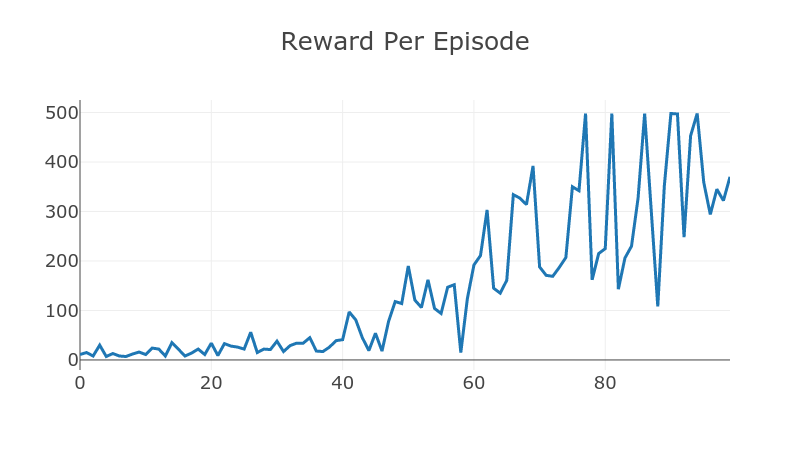

In [97]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(ep_rewards)), y=moving_average(ep_rewards, 1))],
    "layout": go.Layout(title="Reward Per Episode", template="presentation")
})

## Markov Allocation Process

A typical definition for a MDP is as follows:

- state, action, and reward at each time $t \in \{0, 1, 2, ...\}$ are denoted $s_t \in S$, $a_t \in A$, and $r_t \in \mathbb{R}$
- the environment's dynamics are characterized by state transition probabilities, $P^a_{ss'} = Pr\{ s_{t+1} = s' \mid s_t = s, a_t = a\}$ and expected rewards $R^a_s = \mathbb{E}\{r_{t+1} \mid s_t = s, a_t = a\}, \forall s, s' \in S, a\in A$
- the agent's decision making procedure is characterized by a policy, $\pi(s,a,\theta) = Pr\{a_t=a \mid s_t=s,\theta\}, \forall s\in S, a\in A$, where $\theta \in \mathbb{R}^l$, for $l << \left| S \right|$, is a parameter vector.
- we assume $\pi$ is differentiable with respect to its parameter, i.e., that $\frac{\partial\pi(s,a)}{\partial\theta}$ exists.

We suggest a slight alteration to this definition to accommodate tasks which have us optimize resource allocation instead of the task of optimal decision making.  Consider an environment where there a $k$ *assets* we can allocate resources to and from.  Then, we replace the notion of *rewards* with *returns* so that at each time step $t\in \{0,1,2,...\}$, the return is denoted $r_t \in \mathbb{R}^k$.  Our state space is modified to incorporate the current allocation, that is, if $S'$ is the state space offered by the environment, then our working state space $S = S' \times A$.

We also replace our action space with an *allocation space*, $A=\mathbb{R}^k$, where each $a_t \in A$ is a vector of size $k$ where each entry $a_{t,i} \in [0,1]$ and $\sum_{i=1}^k a_{t, i} = 1$.  In essence, this can be achieved through a softmax function, so that an element of our allocation space can be directly computed by our policy $\pi$.  Thus, our policy will no longer be returning a probability, despite it working very similarly to how it normally works.  Formally, the agent's allocation making procedure is characterized by a policy, $\pi: S \times A \rightarrow A$.

## Start-State Formulation

Similar to typical policy gradient methods, we will use something akin to the start-state formulation to represent the performance of our policy.  Unlike the typical formulation, our $\rho$ and $Q^\pi$ aren't scalar values but are instead vectors, where each entry represents the performance of it's corresponding asset.

$$ \rho(\pi)_i = \mathbb{E}\{ \sum_{t=1}^{\infty} \gamma^{t-1} r_{t, i} \mid s_0,\pi\} $$

$$ Q^\pi(s,a)_i = \mathbb{E}\{ \sum_{j=1}^{\infty} \gamma^{j-1} r_{t+j, i} \mid s_t = s, a_t = a, \pi \} $$

where $\gamma \in [0,1]$ is a discount rate.

In this formulation, $\sum_{i=1}^k \rho(\pi)_i$ represents our overall performance.  Naively, this becomes equivalent to our traditional definition of $\rho$, but it is important to note that different configurations of elements of $\rho$ can result in similar overall rewards.  For example, if $\rho = < 1, 0, -1 >$, it will have the same value for it's overall performance as $\rho' = < 0, -1, 1 >$, despite these vectors having very different components.

We define $d^\pi (s)$ as a discounted weighting of states encountered starting at $s_0$ and the following $\pi$:

$$ d^\pi(s) = \sum_{t=0}^{\infty} \gamma^t Pr\{s_t=s \mid s_0,\pi\}$$

## Policy Gradient with Approximation

If we can approximate $Q^\pi$ by a learned function, we can use it in place of $Q^pi$ in the above theorem and still point roughly in the direction of the gradient.

Let $f_w : S \times A \rightarrow \mathbb{R}^k$ be our approximation to $Q^\pi$ with parameter $w$.  It is natural to learn $f_w$ by following $\pi$ and updating $w$ by a rule such as

$$ \Delta w_t 
\; \propto \;
\frac{\partial}{\partial w}[\hat{Q}^\pi(s_t, a_t) - f_w (s_t, a_t)]^2 
\; \propto \;
[ \hat{Q}^\pi (s_t, a_t) - f_w(s_t, a_t)] \frac{\partial f_w (s_t, a_t)}{\partial w} $$

where $\hat{Q}^\pi$ is some unbiased estimator of $Q^\pi(s_t,a_t)$, perhaps $R_t$

When such a process has converged to a local optimum, then

$$
\sum_s d^\pi(s) \sum_a \pi(s,a)[Q^\pi (s,a) - f_w(s,a)] \frac{\partial f_w(s,a)}{\partial w} = 0
$$

We needn't concern ourself with the introduction of vectors here, since we can represent both $\hat{Q}^\pi$ and $f_w$ as a vector of functions, each with the above properties holding true.

## Loss Function

